###### Charging and seeling and buys

(8, 8, 0, 0)
(8, 1, 7, 0)
(11, 11, 0, 7)
(11, 1, 10, 0)
(12, 12, 0, 3)
(14, 14, 0, 0)
(18, 18, 0, 7)
(18, 18, 0, 0)
(18, 1, 17, 0)
(16, 16, 0, 10)


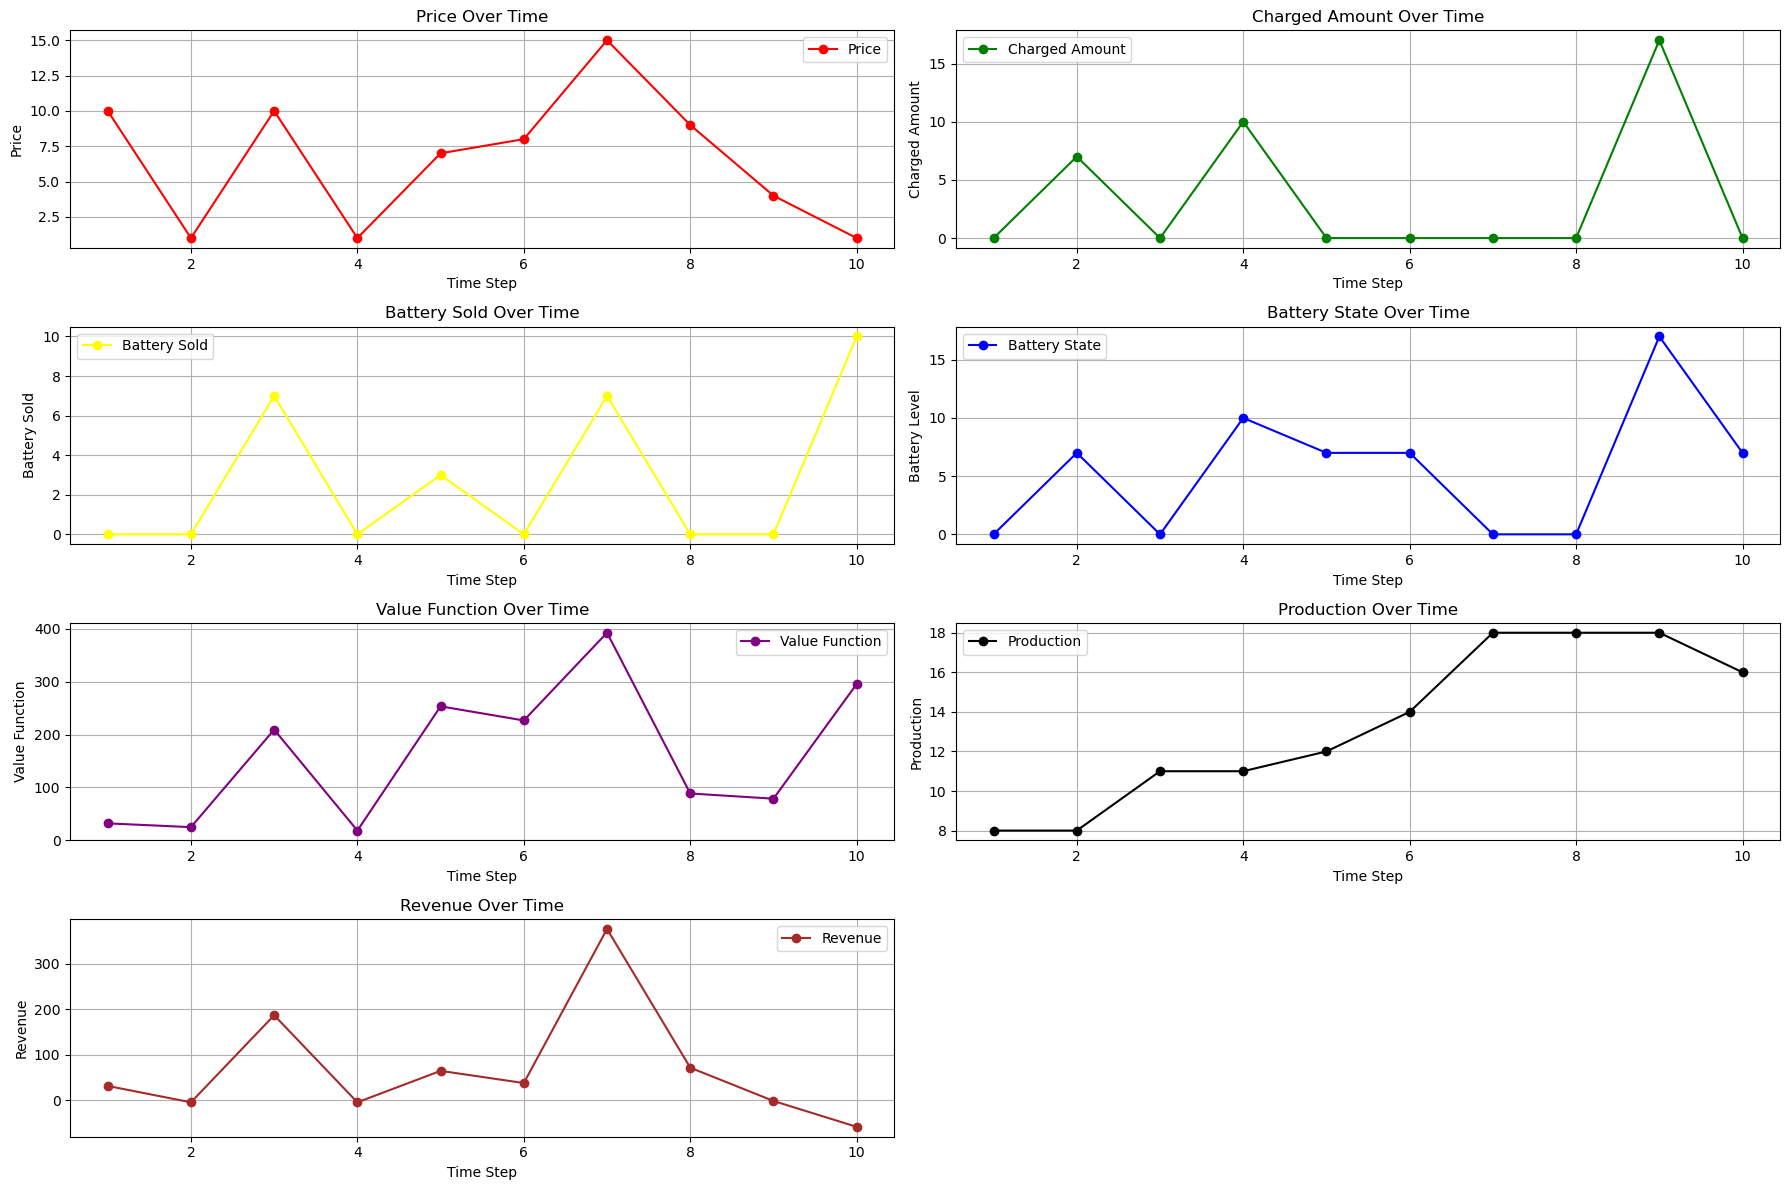

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Constants and parameters
MAX_BATTERY = 100  # Maximum battery capacity
BASE_PRODUCTION_RATE = 5  # Initial production rate
PRODUCTION_RANGE = 13  # Maximum range for production
MAX_PRODUCTION_RATE = BASE_PRODUCTION_RATE + PRODUCTION_RANGE  # Maximum production rate
LEAKAGE_RATE = 0.1  # Leakage rate per step
STORAGE_COST = 0.1  # Cost per energy unit for storage
DISCOUNT_FACTOR = 0.9  # Discount factor for future rewards
TIME_HORIZON = 10  # Number of steps for the simulation
BASE_PRODUCTION_COST = 5  # Base cost for production per unit
PRODUCTION_CHANGE_EXPONENT = 1.9  # Reduced exponent for change in production cost
prices = [10, 1, 10, 1, 7, 8, 15 ,9 , 4, 1]  # Known prices vector

# Production cost function
def production_cost(production):
    # Cost grows linearly with production rate
    return BASE_PRODUCTION_COST * production

# Cost for changing production level
def production_change_cost(prev_production, new_production):
    # Cost grows with smaller exponent for less aggressive penalization
    change = abs(new_production - prev_production)
    return change ** PRODUCTION_CHANGE_EXPONENT

# Bellman update for value iteration with dynamic behavior based on energy prices and battery state
def bellman_update(value_function, state, period, discount_factor, possible_actions, prev_production, prices):
    best_value = -np.inf
    best_action = None
    best_price = None
    best_selling = None
    best_prod_cost = None
    best_change_cost = None
    
    for action in possible_actions:
        production, selling, charging, selling_charge = action
        #print('action',action)
        
        # Apply production and change costs
        prod_cost = production_cost(production)
        change_cost = production_change_cost(prev_production, production)
        
        # Calculate the new battery level
        new_battery = state + production - (selling + charging + selling_charge)
        new_battery = max(0, min(MAX_BATTERY, new_battery))  # Ensure it stays within bounds
        
        # Calculate leakage and storage costs
        storage_cost = new_battery * STORAGE_COST
        leakage = new_battery * LEAKAGE_RATE
        
        # Use known prices for selling energy
        price = prices[period]
        revenue = (price * selling) + (price * selling_charge)
        
        # Calculate the reward
        reward = revenue - prod_cost - change_cost
        #print('reward',reward)
        
        # Calculate the reward
        if period != TIME_HORIZON - 1:
            if selling > 0 or selling_charge > 0:  # Ensure revenue is generated when energy is sold or sold after charging
                if price < BASE_PRODUCTION_COST:
                    reward += (charging) * BASE_PRODUCTION_COST
                else:
                    reward += (selling_charge) * price


        
        # Value update using Bellman equation
        expected_value = reward + discount_factor * value_function[new_battery]
        
        # Keep track of the best action and value
        if expected_value > best_value:
            best_value = expected_value
            best_action = action
            best_price = price
            best_selling = selling
            best_prod_cost = prod_cost
            best_change_cost = change_cost
            best_revenue = reward
    
    return best_value, best_action, best_price, best_selling, best_prod_cost, best_change_cost, best_revenue

# Initialize value function and policy
value_function = np.zeros(MAX_BATTERY + 1)
policy = [(BASE_PRODUCTION_RATE, 0, 0, 0)] * (MAX_BATTERY + 1)  # Start with base production rate
prev_production = BASE_PRODUCTION_RATE  # Initial production rate
battery_states = []  # Store the battery state
charging_amounts = []  # Store the charging amount for each period
selling_charge_amounts = []  # Store the selling charge amount for each period
value_function_value = []  # Store the revenue for each period
productions = []
revenues = []
optimal_battery = 0


def get_possible_actions(last_battery_state):
    possible_actions = []
    for prod in range(BASE_PRODUCTION_RATE, MAX_PRODUCTION_RATE + 1, 1):
        for sell in range(0, prod + 1, 1):  # Selling range (should be less than or equal to production)
            for charge in range(0, min(prod - sell, MAX_BATTERY - sell) + 1):  # Ensure charge is not higher than prod - sell
                max_sell_charge = min(last_battery_state, MAX_BATTERY - charge)
                for sell_charge in range(0, max_sell_charge + 1):  # Ensure sell_charge is not higher than battery state
                    if sell + charge == prod:
                        possible_actions.append((prod, sell, charge, sell_charge))

    return possible_actions



for period in range(TIME_HORIZON):
    # Update possible actions based on the last period's battery state
    possible_actions = get_possible_actions(optimal_battery if battery_states else 0)
    #print(optimal_battery)

    new_value_function = np.copy(value_function)
    
    # Update the value function and calculate the battery state at each time step
    best_value, best_action, best_price, best_selling, best_prod_cost, best_change_cost, best_revenue = bellman_update(value_function, optimal_battery, period, DISCOUNT_FACTOR, possible_actions, prev_production, prices)
    
    if best_action:
        print(best_action)
        new_value_function[optimal_battery] = best_value
        policy[optimal_battery] = best_action
        prev_production = best_action[0]  # Update previous production

        # Calculate the optimal battery state
        optimal_battery = optimal_battery + best_action[0] - best_action[1] - best_action[3]
        #print('optimal_battery', optimal_battery)
        #print('best_action[0]', best_action[0])
        #print('best_action[1]', best_action[1])
        #print('best_action[3]', best_action[3])
        optimal_battery = max(0, min(MAX_BATTERY, optimal_battery))

        battery_states.append(optimal_battery)  # Store the battery state
        charging_amounts.append(best_action[2])  # Store the charging amount
        selling_charge_amounts.append(best_action[3])  # Store the selling charge amount
        productions.append(best_action[0]) 
        value_function_value.append(best_value)  # Store the revenue
        revenues.append(best_revenue)
        
        #print(f"Period {period + 1} - Production: {best_action[0]}, Sold: {best_action[1]}, Charged: {best_action[2]}, Battery State: {optimal_battery}, Revenue: {best_revenue}, Price: {best_price}, Selling: {best_selling}, Production Cost: {best_prod_cost}, Change Cost: {best_change_cost}")

    value_function = new_value_function

    
    
    

# Plot 
plt.figure(figsize=(18, 12))

# Plot Prices
plt.subplot(4, 2, 1)
plt.plot(range(1, TIME_HORIZON + 1), prices[:TIME_HORIZON], marker='o', linestyle='-', color='r', label='Price')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.title('Price Over Time')
plt.grid(True)
plt.legend()

# Plot Charged Amount
plt.subplot(4, 2, 2)
plt.plot(range(1, TIME_HORIZON + 1), charging_amounts, marker='o', linestyle='-', color='g', label='Charged Amount')
plt.xlabel('Time Step')
plt.ylabel('Charged Amount')
plt.title('Charged Amount Over Time')
plt.grid(True)
plt.legend()

# Plot Battery Sold Amount
plt.subplot(4, 2, 3)
plt.plot(range(1, TIME_HORIZON + 1), selling_charge_amounts, marker='o', linestyle='-', color='yellow', label='Battery Sold')
plt.xlabel('Time Step')
plt.ylabel('Battery Sold')
plt.title('Battery Sold Over Time')
plt.grid(True)
plt.legend()

# Plot Battery State
plt.subplot(4, 2, 4)
plt.plot(range(1, TIME_HORIZON + 1), battery_states, marker='o', linestyle='-', color='b', label='Battery State')
plt.xlabel('Time Step')
plt.ylabel('Battery Level')
plt.title('Battery State Over Time')
plt.grid(True)
plt.legend()

# Plot Revenue
plt.subplot(4, 2, 5)
plt.plot(range(1, TIME_HORIZON + 1), value_function_value, marker='o', linestyle='-', color='purple', label='Value Function')
plt.xlabel('Time Step')
plt.ylabel('Value Function')
plt.title('Value Function Over Time')
plt.grid(True)
plt.legend()

# Plot Production
plt.subplot(4, 2, 6)
plt.plot(range(1, TIME_HORIZON + 1), productions, marker='o', linestyle='-', color='black', label='Production')
plt.xlabel('Time Step')
plt.ylabel('Production')
plt.title('Production Over Time')
plt.grid(True)
plt.legend()

# Plot Production
plt.subplot(4, 2, 7)
plt.plot(range(1, TIME_HORIZON + 1), revenues, marker='o', linestyle='-', color='brown', label='Revenue')
plt.xlabel('Time Step')
plt.ylabel('Revenue')
plt.title('Revenue Over Time')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()